# Data Preprocess

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numba import njit,jit
import pandas as pd
import os

In [3]:
btc_raw = pd.read_csv("../data/btc_PERP.csv",parse_dates=True, index_col='startTime')
funding_raw = pd.read_csv("../data/BTC_funding.csv",parse_dates=True, index_col='time')

# Resample

In [5]:
rule = '1H'

d1 = btc_raw.resample(rule=rule, closed='left', label='left').first()[['open']]
d2 = btc_raw.resample(rule=rule, closed='left', label='left').max()[['high']]
d3 = btc_raw.resample(rule=rule, closed='left', label='left').min()[['low']]
d4 = btc_raw.resample(rule=rule, closed='left', label='left').last()[['close']]
d5 = btc_raw.resample(rule=rule, closed='left', label='left').sum()[['volume']]


btc = pd.concat([d1,d2,d3,d4,d5], axis=1)
btc.head(10)

,open,high,low,close,volume
startTime,,,,,
2020-12-31 16:00:00+00:00,28795.5,28838.0,28320.0,28388.5,1.002989e+08
2020-12-31 17:00:00+00:00,28392.5,28737.5,28355.5,28580.0,8.650366e+07
2020-12-31 18:00:00+00:00,28580.5,28921.5,28494.5,28884.0,5.824629e+07
2020-12-31 19:00:00+00:00,28884.0,29200.0,28770.0,28929.5,9.426918e+07
2020-12-31 20:00:00+00:00,28929.5,29196.5,28903.0,29183.0,5.325351e+07
2020-12-31 21:00:00+00:00,29183.0,29213.5,28937.5,28990.0,7.514510e+07
2020-12-31 22:00:00+00:00,28990.0,29183.5,28930.5,29137.5,3.725953e+07
2020-12-31 23:00:00+00:00,29137.5,29142.5,28816.0,28956.5,7.821744e+07
2021-01-01 00:00:00+00:00,28956.0,29080.0,28731.5,29045.5,7.721627e+07


In [6]:
rule = '1H'
btc_hour = btc_raw.resample(rule=rule, closed='right', label='right').first()[['open']]

df_funding = pd.concat([btc_hour, funding_raw], axis=1)
df_funding = df_funding.fillna(method='bfill', limit=2).fillna(0)
df_funding.head(10)

,open,rate
2020-12-31 16:00:00+00:00,28795.5,-0.000007
2020-12-31 17:00:00+00:00,28829.0,-0.000007
2020-12-31 18:00:00+00:00,28414.5,-0.000016
2020-12-31 19:00:00+00:00,28550.5,-0.000017
2020-12-31 20:00:00+00:00,28878.0,-0.000014
2020-12-31 21:00:00+00:00,28951.0,0.000001
2020-12-31 22:00:00+00:00,29166.5,-0.000004
2020-12-31 23:00:00+00:00,29033.5,-0.000008
2021-01-01 00:00:00+00:00,29099.0,-0.000010
2021-01-01 01:00:00+00:00,29000.5,-0.000020


# 切分樣本內外

<AxesSubplot:xlabel='startTime'>

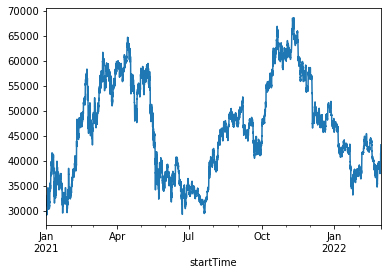

In [7]:
btc_inSample = btc["2021-01-01 00:00:00+00:00":"2022-02-28 23:59:59+00:00"]
btc_inSample["close"].plot()

<AxesSubplot:xlabel='startTime'>

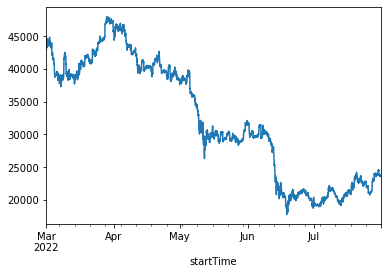

In [8]:
btc_outOfSample = btc["2022-03-01 00:00:00+00:00":"2022-07-31 23:59:59+00:00"]
btc_outOfSample["close"].plot()

# 計算指標

In [700]:
from talib import abstract
plt.style.use('seaborn')

## 參數

In [851]:
atrLength = 13
supertrendFactor = 3
B_length = 20
dev_mult = 0.5
macd_fast = 12
macd_slow = 26
macd_length = 48

## SuperTrend

In [826]:
def SuperTrend(df,atrLength,supertrendFactor):
    atr = abstract.ATR(df,timeperiod=atrLength)
    high = df.high
    low = df.low
    close = df.close
    hl2 = ( high + low ) / 2
    basicUpperBand = hl2 + (supertrendFactor * atr)
    basicLowerBand = hl2 - (supertrendFactor * atr)
    upperBand = np.zeros(len(basicUpperBand))
    lowerBand = np.zeros(len(basicLowerBand))
    for i in range(1,len(upperBand)):
        if(basicUpperBand[i] < upperBand[i-1] or close[i-1] > upperBand[i-1]):
            upperBand[i] = 0 if np.isnan(basicUpperBand[i]) else basicUpperBand[i]
        else:
            upperBand[i] = upperBand[i-1]
    for i in range(1,len(lowerBand)):
        if(basicLowerBand[i] > lowerBand[i-1] or close[i-1] < lowerBand[i-1]):
            lowerBand[i] = 0 if np.isnan(basicLowerBand[i]) else basicLowerBand[i]
        else:
            lowerBand[i] = lowerBand[i-1]
    isUpTrend = np.full(len(upperBand),False) # Default DownTrend(false), UpTrend is True
    superTrend = np.copy(upperBand)
    for i in range(1, len(isUpTrend)):
        if(np.isnan(atr[i])):
            isUpTrend[i] = False
        elif superTrend[i-1] == upperBand[i-1]:
            isUpTrend[i] =  True if close[i] > upperBand[i] else False
        else:
            isUpTrend[i] = False if close[i] < lowerBand[i] else True
        superTrend[i] = lowerBand[i] if isUpTrend[i] else upperBand[i]
    isUpTrend = pd.Series(isUpTrend,index = atr.index)
    superTrend = pd.Series(superTrend,index = atr.index)
    return isUpTrend,superTrend

In [852]:
isUpTrend,superTrend = SuperTrend(btc_inSample,atrLength,supertrendFactor)
superTrend

startTime
2021-01-01 00:00:00+00:00        0.000000
2021-01-01 01:00:00+00:00        0.000000
2021-01-01 02:00:00+00:00        0.000000
2021-01-01 03:00:00+00:00        0.000000
2021-01-01 04:00:00+00:00        0.000000
                                 ...     
2022-02-28 19:00:00+00:00    39348.565862
2022-02-28 20:00:00+00:00    39731.868488
2022-02-28 21:00:00+00:00    39882.686297
2022-02-28 22:00:00+00:00    40648.518120
2022-02-28 23:00:00+00:00    40871.170572
Freq: H, Length: 10176, dtype: float64

## Bollinger Bands

In [853]:
BBANDS = abstract.BBANDS(btc_inSample, timeperiod=B_length, nbdevup=dev_mult, nbdevdn=dev_mult, matype=0)
BBANDS

,upperband,middleband,lowerband
startTime,,,
2021-01-01 00:00:00+00:00,NaN,NaN,NaN
2021-01-01 01:00:00+00:00,NaN,NaN,NaN
2021-01-01 02:00:00+00:00,NaN,NaN,NaN
2021-01-01 03:00:00+00:00,NaN,NaN,NaN
2021-01-01 04:00:00+00:00,NaN,NaN,NaN
...,...,...,...
2022-02-28 19:00:00+00:00,39612.429586,38918.00,38223.570414
2022-02-28 20:00:00+00:00,39884.206817,39135.05,38385.893183
2022-02-28 21:00:00+00:00,40104.326353,39319.20,38534.073647


<AxesSubplot:xlabel='startTime'>

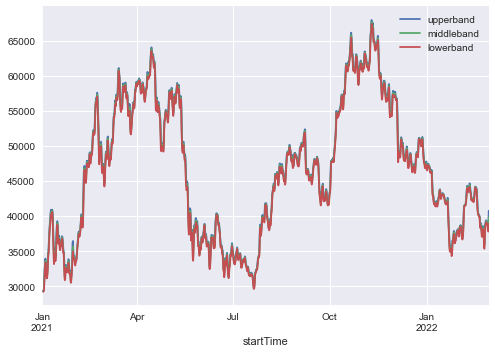

In [854]:
BBANDS.plot()

## MACD

In [855]:
macd = abstract.MACD(btc_inSample,fastperiod=macd_fast, slowperiod=macd_slow, signalperiod=macd_length)
macd

,macd,macdsignal,macdhist
startTime,,,
2021-01-01 00:00:00+00:00,NaN,NaN,NaN
2021-01-01 01:00:00+00:00,NaN,NaN,NaN
2021-01-01 02:00:00+00:00,NaN,NaN,NaN
2021-01-01 03:00:00+00:00,NaN,NaN,NaN
2021-01-01 04:00:00+00:00,NaN,NaN,NaN
...,...,...,...
2022-02-28 19:00:00+00:00,718.622574,28.549852,690.072722
2022-02-28 20:00:00+00:00,818.361876,60.787077,757.574799
2022-02-28 21:00:00+00:00,866.677719,93.680573,772.997146


# 回測

In [856]:
fund = 10000 
money = 10000 
feeRate = 0.0015

In [857]:
def fundingPayment(btc_funding, side, unit, t1, t2):
    
    if len(btc_funding.loc[t1:t2]) == 0:
        fee = 0
    else:
        fr = np.array(btc_funding.loc[t1:t2])
        fee = unit * np.dot(fr[:,0],fr[:,1])
        
    if side == 'long':
        return -fee
    elif side == 'short':
        return fee

In [859]:
class Simulator:
    def __init__(self):
        self.buy = []
        self.sell = []
        self.sellshort = []
        self.buytocover = []
        self.profit_list = [0,0]
        self.profit_fee_list = [0,0]
        self.profit_fee_list_realized = []
    # TODO: 把dataframe從function拿出來，用numba平行化for loop，不能用numba的用multiprocessing
    # TODO: Generalize交易條件，改成Input Generate出來的信號，切分進場出場停利停損
    def back_sim(self,df,isUpTrend,macd,BBANDS):
        BS = ""
        time_arr = np.array(df.index)
        df_arr = np.array(df)
        isUpTrend_arr = np.array(isUpTrend)
        macd_arr = np.array(macd)[:,2] #macdhist
        BBANDS_arr = np.array(BBANDS)
        stop_lower = np.nan
        stop_upper = np.nan
        for i in range(1,len(df_arr)):

            if i == len(df_arr)-1:
                break

            if BS == "":
                self.profit_list.append(0)
                self.profit_fee_list.append(0)
                
                if macd_arr[i-1] < 0 and macd_arr[i] > 0 and isUpTrend_arr[i]:
                    tempSize = money / df_arr[i+1,0]
                    BS = 'B'
                    t = i+1
                    self.buy.append(t)
                    t1 = time_arr[i+1]
                    stop_lower = BBANDS_arr[i,2] # lowerband
                    

                elif macd_arr[i-1] > 0 and macd_arr[i] < 0 and (not isUpTrend_arr[i]):
                    tempSize = money / df_arr[i+1,0]
                    BS = 'S'
                    t = i+1
                    self.sellshort.append(t)
                    t1 = time_arr[i+1]
                    stop_upper = BBANDS_arr[i,0] #upperband
                
            elif BS == 'B':
                profit = tempSize * (df_arr[i+1,0] - df_arr[i,0])
                self.profit_list.append(profit)
                t2 = time_arr[i+1]
                fundingFee = fundingPayment(df_funding, 'long', tempSize, time_arr[t], t2)
                    
                if  (macd_arr[i-1] > 0 and macd_arr[i] < 0 and (not isUpTrend_arr[i])) or df_arr[i,3] < stop_lower or i == len(df_arr)-2:
                    pl_round = tempSize * (df_arr[i+1,0] - df_arr[t,0])
                    profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
                    self.profit_fee_list.append(profit_fee)
                    self.sell.append(i+1)
                    BS=""
                    
                    # Realized PnL
                    profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
                    self.profit_fee_list_realized.append(profit_fee_realized)
                    
                else:
                    profit_fee = profit
                    self.profit_fee_list.append(profit_fee)
                    t1 = time_arr[i+1]
                    
            elif BS == 'S': 
                profit = tempSize * (df_arr[i,0] - df_arr[i+1,0])
                self.profit_list.append(profit)
                t2 = time_arr[i+1]
                fundingFee = fundingPayment(df_funding, 'short', tempSize, time_arr[t], t2)
                
                if  (macd_arr[i-1] < 0 and macd_arr[i] > 0 and isUpTrend_arr[i]) or df_arr[i,3] > stop_upper  or i == len(df_arr)-2:
                    pl_round = tempSize * (df_arr[t,0] - df_arr[i+1,0])
                    profit_fee = profit - money*feeRate - (money+pl_round)*feeRate + fundingFee
                    self.profit_fee_list.append(profit_fee)
                    self.buytocover.append(i+1)
                    BS=""
                    
                    # Realized PnL
                    profit_fee_realized = pl_round - money*feeRate - (money+pl_round)*feeRate + fundingFee
                    self.profit_fee_list_realized.append(profit_fee_realized)
        
                else:
                    profit_fee = profit
                    self.profit_fee_list.append(profit_fee)
                    t1 = time_arr[i+1]
                    
        equity = pd.DataFrame({'profit':np.cumsum(self.profit_list), 'profitfee':np.cumsum(self.profit_fee_list)}, index=df.index)
        equity['equity'] = equity['profitfee'] + fund
        equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
        equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
        ret = equity['equity'][-1]/equity['equity'][0] - 1
        mdd = abs(equity['drawdown_percent'].min())
        calmarRatio = ret / mdd
        #equity.plot(grid=True, figsize=(12, 6));
        return equity,ret,mdd,calmarRatio

In [860]:
inSample_sim = Simulator()
equity,ret,mdd,calmarRatio = inSample_sim.back_sim(btc_inSample,isUpTrend,macd,BBANDS)

# 計算績效

## 實際交易位置

In [835]:
# 實際交易位置
print(inSample_sim.buy)
print(inSample_sim.sell)
print(inSample_sim.sellshort)
print(inSample_sim.buytocover)

[111, 180, 296, 546, 578, 865, 1131, 1557, 1924, 2098, 2379, 2431, 2931, 3608, 4188, 4293, 4305, 4875, 4992, 5202, 5447, 5619, 5680, 5761, 5893, 6245, 6643, 7274, 7316, 7326, 7529, 8032, 8562, 8820, 9091, 9453, 9497, 9653, 10167]
[171, 234, 380, 547, 599, 1105, 1281, 1871, 1937, 2262, 2397, 2523, 2953, 3731, 4215, 4299, 4336, 4966, 5194, 5412, 5463, 5654, 5694, 5763, 5985, 6277, 7119, 7277, 7317, 7386, 7532, 8037, 8665, 8823, 9161, 9476, 9550, 9734, 10175]
[630, 859, 1342, 1894, 1990, 2557, 2683, 3019, 3160, 3564, 3787, 4022, 4111, 4441, 4511, 4691, 4767, 5487, 5785, 6063, 6333, 6394, 6523, 7300, 7408, 7567, 7648, 7856, 8080, 8712, 8756, 8854, 8875, 9201, 9239, 9420, 9818, 9968]
[665, 861, 1471, 1918, 2057, 2655, 2761, 3037, 3483, 3588, 3814, 4100, 4146, 4470, 4596, 4736, 4840, 5539, 5850, 6142, 6352, 6443, 6529, 7304, 7441, 7632, 7792, 7869, 8372, 8731, 8801, 8865, 9000, 9204, 9330, 9422, 9829, 10076]


In [836]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

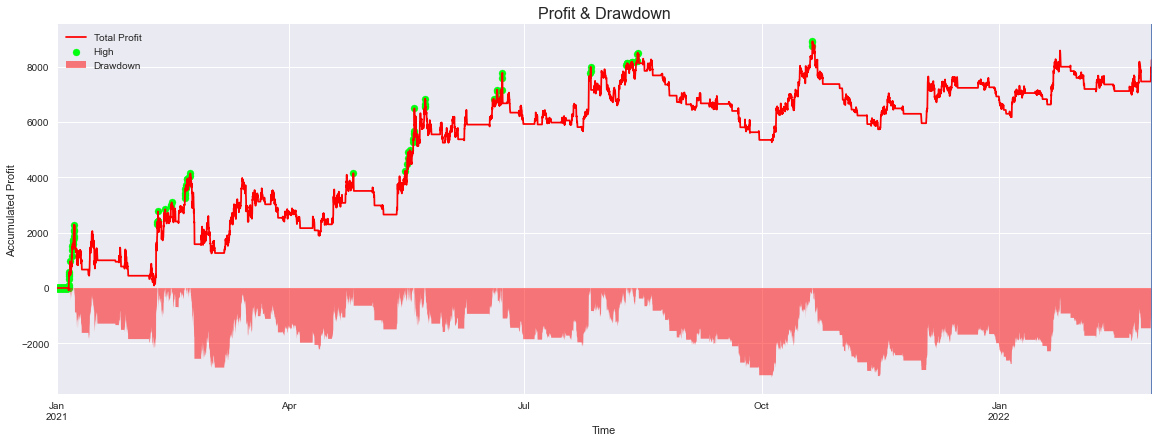

In [837]:
fig, ax = plt.subplots(figsize = (16,6))


high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')
plt.axvline(x="2022-03-01 00:00:00+00:00")
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);


In [838]:
def plot_entry(df,simulator):
    buy,sell,sellshort,buytocover = simulator.buy,simulator.sell,simulator.sellshort,simulator.buytocover
    fig, ax = plt.subplots(figsize = (16,6))
    df['close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
    plt.scatter(df['close'].iloc[buy].index, df['close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
    plt.scatter(df['close'].iloc[sell].index, df['close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
    plt.scatter(df['close'].iloc[sellshort].index, df['close'].iloc[sellshort],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
    plt.scatter(df['close'].iloc[buytocover].index, df['close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)

    plt.legend()
    plt.ylabel('USD')
    plt.xlabel('Time')
    plt.title('Price Movement',fontsize  = 16);

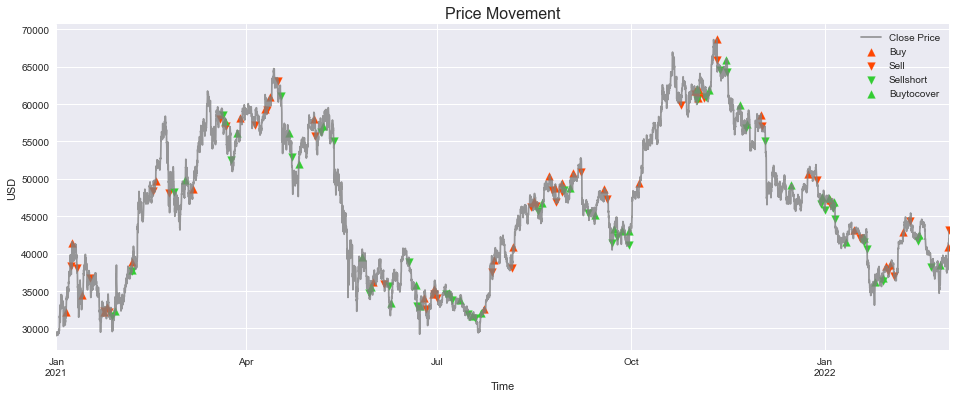

In [839]:
plot_entry(btc_inSample,inSample_sim)

In [842]:
def calc_performance(simulator,equity):
    profit = equity['profitfee'].iloc[-1]
    ret = equity['equity'][-1]/equity['equity'][0] - 1
    annual_ret = ret/(len(equity)/24/365)
    daily_ret = ((equity["profitfee"]/money) - (equity["profitfee"]/money).shift(1)).dropna().resample(rule="1D",closed="right",label="right").sum()
    ret_stddev =np.std(daily_ret.values) * np.sqrt(365)
    # hr_ret = ((equity["profitfee"]/money) - (equity["profitfee"]/money).shift(1)).dropna()
    # ret_stddev = np.std(hr_ret.values) * np.sqrt(365*24)
    sharpeRatio = annual_ret / ret_stddev
    mdd = abs(equity['drawdown_percent'].min())
    calmarRatio = ret / mdd
    tradeTimes = len(simulator.buy)+len(simulator.sellshort)
    winRate = len([i for i in simulator.profit_fee_list_realized if i > 0]) / len(simulator.profit_fee_list_realized)
    profitFactor = sum([i for i in simulator.profit_fee_list_realized if i > 0]) / abs(sum([i for i in simulator.profit_fee_list_realized if i < 0]))
    winLossRatio = np.mean([i for i in simulator.profit_fee_list_realized if i > 0]) / abs(np.mean([i for i in simulator.profit_fee_list_realized if i < 0]))

    print(f'profit: ${np.round(profit,2)}')
    print(f'return: {np.round(ret,4)*100}%')
    print(f'annual return: {np.round(annual_ret,4)*100}%')
    print(f'volatility: {np.round(ret_stddev,4)*100}%')
    print(f'sharpeRatio: {np.round(sharpeRatio,2)}')
    print(f'mdd: {np.round(mdd,4)*100}%')
    print(f'calmarRatio: {np.round(calmarRatio,2)}')
    print(f'tradeTimes: {tradeTimes}')
    print(f'winRate: {np.round(winRate,4)*100}%')
    print(f'profitFactor: {np.round(profitFactor,2)}')
    print(f'winLossRatio: {np.round(winLossRatio,2)}')

In [843]:
calc_performance(inSample_sim,equity)

profit: $8243.97
return: 82.44%
annual return: 70.97%
volatility: 61.61%
sharpeRatio: 1.15
mdd: 20.46%
calmarRatio: 4.03
tradeTimes: 77
winRate: 33.77%
profitFactor: 1.6
winLossRatio: 3.13


# 最佳化

In [82]:
from tqdm import trange

In [467]:
def optimize():
    optimizationList = []
    for atrLength in trange(5,100,5):
        for macd_length in range(5,100,5):
            for dev_mult in np.arange(0.5,2,0.5):
                isUpTrend,superTrend = SuperTrend(btc_inSample,atrLength,supertrendFactor)
                BBANDS = abstract.BBANDS(btc_inSample, timeperiod=B_length, nbdevup=dev_mult, nbdevdn=dev_mult, matype=0)
                macd = abstract.MACD(btc_inSample,fastperiod=macd_fast, slowperiod=macd_slow, signalperiod=macd_length)
                inSample_sim = Simulator()
                equity,ret,mdd,calmarRatio = inSample_sim.back_sim(btc_inSample,isUpTrend,macd,BBANDS)
                optimizationList.append([atrLength, macd_length,dev_mult, ret, calmarRatio])
    return optimizationList
optimizationList = optimize()
optResult = pd.DataFrame(optimizationList, columns=['atrLength','macd_length','dev_mult','ret','calmarRatio'])


100%|██████████| 19/19 [14:29<00:00, 45.77s/it]


In [574]:
def optimize():
    optimizationList = []
    for atrLength in trange(5,25,2):
        for macd_length in range(40,60,2):
            isUpTrend,superTrend = SuperTrend(btc_inSample,atrLength,supertrendFactor)
            BBANDS = abstract.BBANDS(btc_inSample, timeperiod=B_length, nbdevup=dev_mult, nbdevdn=dev_mult, matype=0)
            macd = abstract.MACD(btc_inSample,fastperiod=macd_fast, slowperiod=macd_slow, signalperiod=macd_length)
            inSample_sim = Simulator()
            equity,ret,mdd,calmarRatio = inSample_sim.back_sim(btc_inSample,isUpTrend,macd,BBANDS)
            optimizationList.append([atrLength, macd_length,dev_mult, ret, calmarRatio])
    return optimizationList
optimizationList = optimize()
optResult = pd.DataFrame(optimizationList, columns=['atrLength','macd_length','dev_mult','ret','calmarRatio'])

100%|██████████| 10/10 [01:43<00:00, 10.31s/it]


In [575]:
optResult.sort_values('ret', ascending=False)

,atrLength,macd_length,dev_mult,ret,calmarRatio
44,13,48,0.5,0.768994,4.083325
43,13,46,0.5,0.643839,2.897125
45,13,50,0.5,0.640755,3.109531
42,13,44,0.5,0.618152,2.850357
34,11,48,0.5,0.587239,1.889573
...,...,...,...,...,...
18,7,56,0.5,0.038952,0.124196
19,7,58,0.5,-0.000272,-0.000821
26,9,52,0.5,-0.004557,-0.011546
28,9,56,0.5,-0.012220,-0.031319


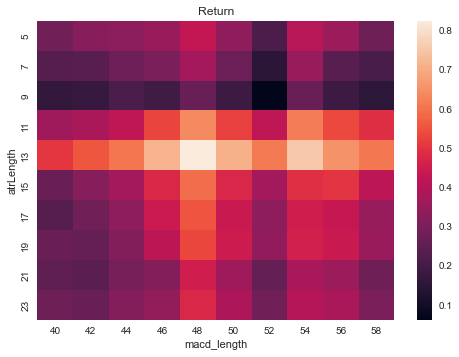

In [291]:
#pic = optResult.pivot_table('atrLength', 'B_length', 'ret')
pic = optResult.pivot_table(index='atrLength', columns='macd_length',values='ret',aggfunc='median')
sns.heatmap(data = pic).set(title='Return');

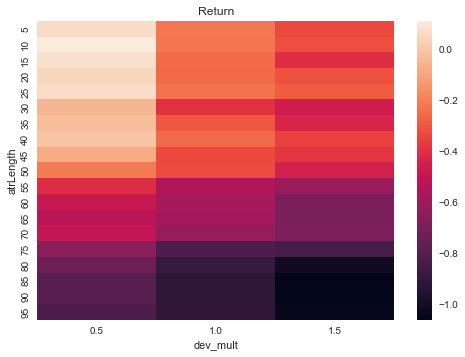

In [244]:
pic = optResult.pivot_table(index='atrLength', columns='dev_mult',values='ret',aggfunc='median')
sns.heatmap(data = pic).set(title='Return');

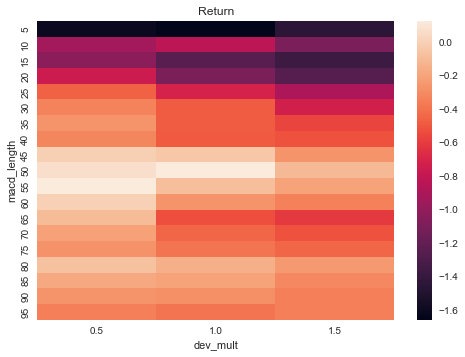

In [245]:

pic = optResult.pivot_table(index='macd_length', columns='dev_mult',values='ret',aggfunc='median')
sns.heatmap(data = pic).set(title='Return');

# 樣本外

In [809]:
isUpTrend,superTrend = SuperTrend(btc_outOfSample,atrLength,supertrendFactor)
BBANDS = abstract.BBANDS(btc_outOfSample, timeperiod=B_length, nbdevup=dev_mult, nbdevdn=dev_mult, matype=0)
macd = abstract.MACD(btc_outOfSample,fastperiod=macd_fast, slowperiod=macd_slow, signalperiod=macd_length)

In [810]:
outOfSample_sim = Simulator()
equity,ret,mdd,calmarRatio = outOfSample_sim.back_sim(btc_outOfSample,isUpTrend,macd,BBANDS)

In [811]:
# 實際交易位置
print(outOfSample_sim.buy)
print(outOfSample_sim.sell)
print(outOfSample_sim.sellshort)
print(outOfSample_sim.buytocover)

[426, 839, 1235, 2201, 2809, 3045, 3305, 3375, 3640]
[818, 855, 1243, 2213, 2827, 3200, 3357, 3523, 3646]
[147, 259, 301, 856, 1216, 1321, 1359, 1634, 2269, 2353, 2388, 2844, 2985, 3036, 3212, 3363]
[158, 275, 320, 1170, 1226, 1337, 1544, 2086, 2330, 2373, 2649, 2929, 2996, 3044, 3234, 3374]


In [812]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

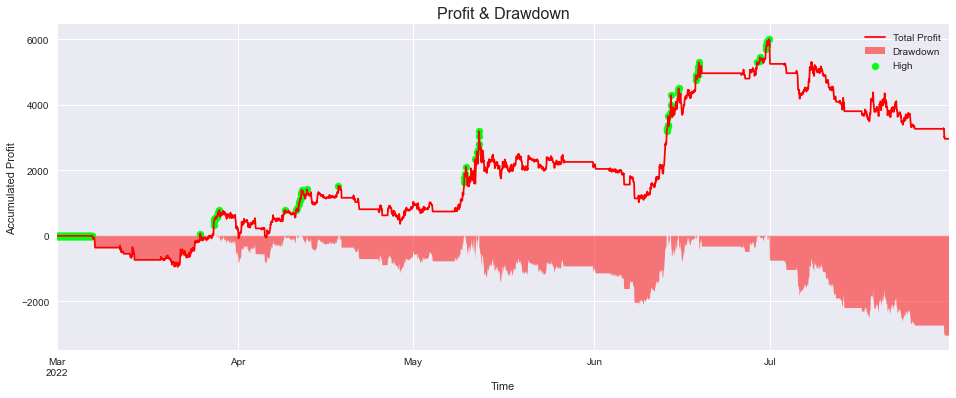

In [813]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

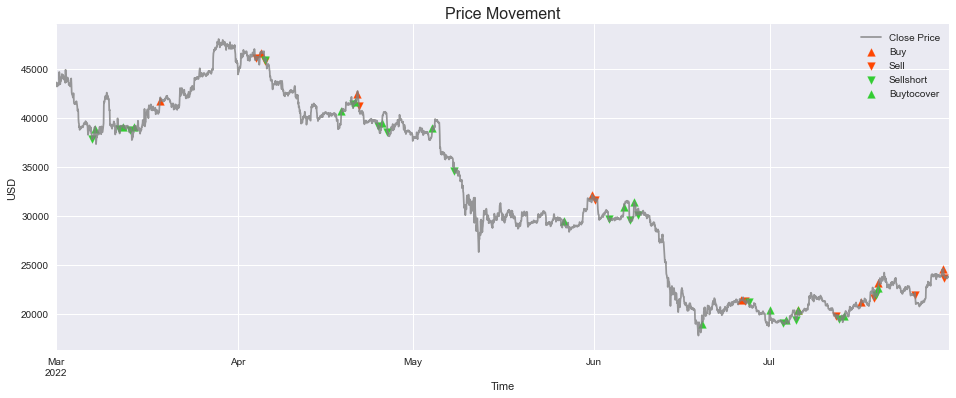

In [814]:
plot_entry(btc_outOfSample,outOfSample_sim)

In [815]:
calc_performance(outOfSample_sim,equity)

profit: $2960.18
return: 29.599999999999998%
annual return: 70.73%
volatility: 51.18000000000001%
sharpeRatio: 1.38
mdd: 19.009999999999998%
Rate of risk return on investment: 1.56
calmarRatio: 1.56
tradeTimes: 25
winRate: 24.0%
profitFactor: 1.59
winLossRatio: 5.02


# 合併計算

In [844]:
isUpTrend,superTrend = SuperTrend(btc,atrLength,supertrendFactor)
BBANDS = abstract.BBANDS(btc, timeperiod=B_length, nbdevup=dev_mult, nbdevdn=dev_mult, matype=0)
macd = abstract.MACD(btc,fastperiod=macd_fast, slowperiod=macd_slow, signalperiod=macd_length)
allSample_sim = Simulator()
equity,ret,mdd,calmarRatio = allSample_sim.back_sim(btc,isUpTrend,macd,BBANDS)
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()

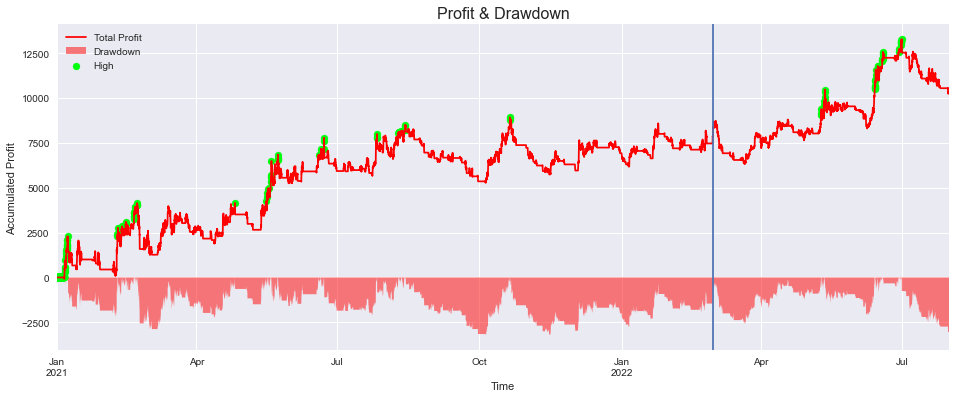

In [845]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.axvline(x="2022-03-01 00:00:00+00:00")
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);

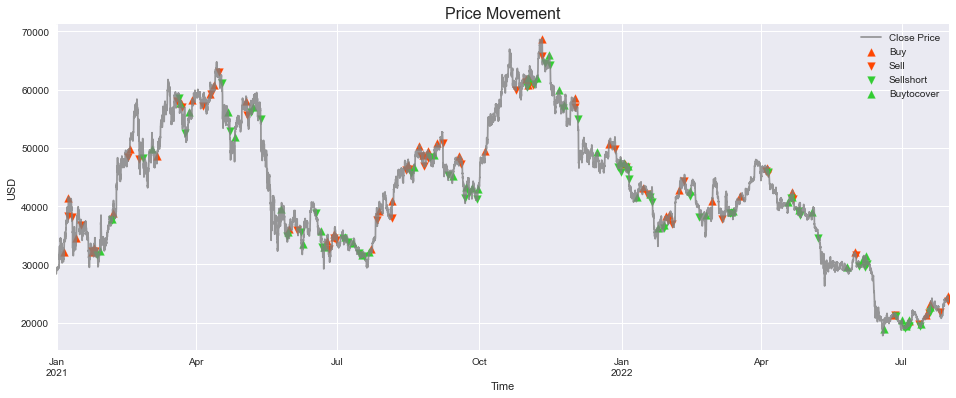

In [846]:
plot_entry(btc,allSample_sim)

In [847]:
calc_performance(allSample_sim,equity)

profit: $10237.79
return: 102.38000000000001%
annual return: 64.75%
volatility: 59.540000000000006%
sharpeRatio: 1.09
mdd: 20.46%
calmarRatio: 5.0
tradeTimes: 101
winRate: 30.69%
profitFactor: 1.54
winLossRatio: 3.47


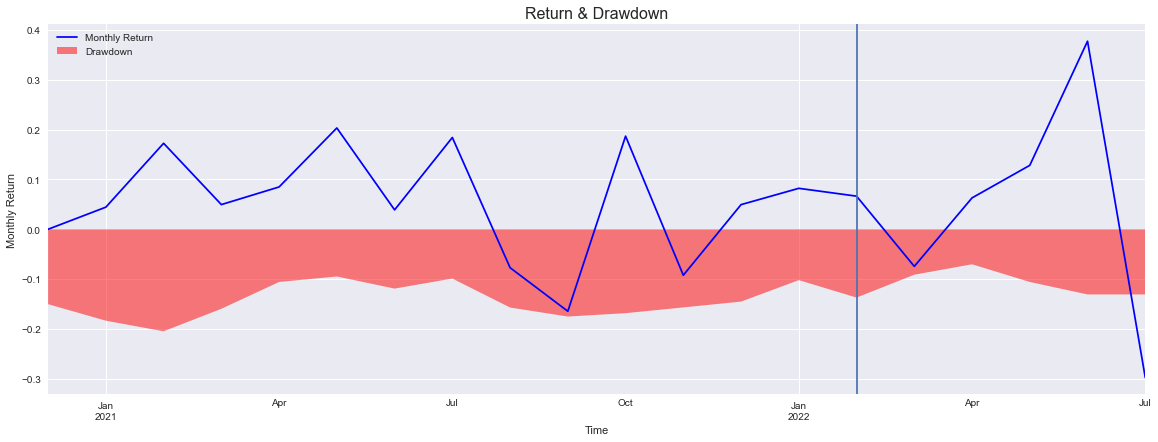

In [848]:
fig, ax = plt.subplots(figsize = (16,6))

month_ret = ((equity["profitfee"]/money) - (equity["profitfee"]/money).shift(1)).dropna().resample(rule="1M",closed="right",label="right").sum()
month_ret.plot(label = 'Monthly Return', ax = ax, c = 'b', grid=True)
plt.axvline(x="2022-02-28 00:00:00+00:00")
month_mdd = equity['drawdown_percent'].resample(rule='1M', closed='left', label='left').min()
plt.fill_between(month_mdd.index, month_mdd, 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.ylabel('Monthly Return')
plt.xlabel('Time')
plt.title('Return & Drawdown',fontsize  = 16);

In [849]:
month_ret

startTime
2020-12-31 00:00:00+00:00    0.000000
2021-01-31 00:00:00+00:00    0.044320
2021-02-28 00:00:00+00:00    0.172350
2021-03-31 00:00:00+00:00    0.049456
2021-04-30 00:00:00+00:00    0.084805
2021-05-31 00:00:00+00:00    0.203049
2021-06-30 00:00:00+00:00    0.038845
2021-07-31 00:00:00+00:00    0.183970
2021-08-31 00:00:00+00:00   -0.077063
2021-09-30 00:00:00+00:00   -0.164428
2021-10-31 00:00:00+00:00    0.186662
2021-11-30 00:00:00+00:00   -0.092195
2021-12-31 00:00:00+00:00    0.049366
2022-01-31 00:00:00+00:00    0.082065
2022-02-28 00:00:00+00:00    0.066371
2022-03-31 00:00:00+00:00   -0.074424
2022-04-30 00:00:00+00:00    0.062872
2022-05-31 00:00:00+00:00    0.128141
2022-06-30 00:00:00+00:00    0.377001
2022-07-31 00:00:00+00:00   -0.297386
Freq: M, Name: profitfee, dtype: float64